
# Google Play Store EDA
**Author:** Paritosh Verma  
**Notebook Name:** ParitoshVerma_GPlay_EDA

This notebook performs a complete, reproducible EDA of the provided Google Play Store dataset—covering setup, loading, cleaning, univariate and bivariate analysis, data quality, and a short insights summary.


## 1) Setup

In [1]:
# Importing the necessary modules
import re, math, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Charts: keep single-plot figures and avoid forcing colors/styles.
%matplotlib inline


## 2) Load the dataset

In [2]:
# Loading the dataset
csv_path = 'googleplaystore.csv'

df_raw = pd.read_csv(csv_path)
df = df_raw.copy()
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


## 3) Initial data scan

In [3]:
# Quick viewing of the data
print("Shape:", df.shape)
print("\nDtypes:\n", df.dtypes)
print("\nMissing counts:\n", df.isna().sum())
print("\nSample rows:")
df.head(3)

Shape: (10841, 13)

Dtypes:
 App                object
Category           object
Rating            float64
Reviews            object
Size               object
Installs           object
Type               object
Price              object
Content Rating     object
Genres             object
Last Updated       object
Current Ver        object
Android Ver        object
dtype: object

Missing counts:
 App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64

Sample rows:


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up


## 4) Data cleaning


In [4]:
import re
from datetime import datetime

# Defining functions to clean the data
def to_int_installs(x):
    if pd.isna(x): return np.nan
    s = str(x).strip().replace('+','').replace(',','').strip()
    if s == '' or s.lower() == 'nan': return np.nan
    try: return int(float(s))
    except: return np.nan

def to_float_price(x):
    if pd.isna(x): return np.nan
    s = re.sub(r'[^\d\.\-]', '', str(x))
    if s in ['', '.']: return 0.0
    try: return float(s)
    except: return np.nan

def to_float_rating(x):
    try:
        v = float(x)
        return v if 0 <= v <= 5 else np.nan
    except:
        return np.nan

def to_float_reviews(x):
    try: return float(str(x).replace(',','').strip())
    except: return np.nan

def size_to_mb(x):
    if pd.isna(x): return np.nan
    s = str(x).strip()
    if s.lower().startswith('varies'): return np.nan
    s = s.replace(' ', '').replace(',', '.')
    m = re.match(r'^([0-9]*\.?[0-9]+)([kKmMgG]?)$', s)
    if not m: return np.nan
    val = float(m.group(1)); unit = m.group(2).upper() if m.group(2) else 'M'
    if unit == 'K': return val/1024.0
    if unit == 'M': return val
    if unit == 'G': return val*1024.0
    return np.nan

def first_genre(x):
    if pd.isna(x): return np.nan
    return str(x).split(';')[0].strip()

def parse_date(x):
    for fmt in ("%B %d, %Y", "%b %d, %Y", "%Y-%m-%d", "%d-%m-%Y", "%m/%d/%Y"):
        try: return pd.to_datetime(x, format=fmt)
        except: pass
    return pd.to_datetime(x, errors='coerce')

# Applying cleaning
if 'Installs' in df.columns: df['Installs_clean'] = df['Installs'].apply(to_int_installs)
if 'Price' in df.columns: df['Price_clean'] = df['Price'].apply(to_float_price)
if 'Rating' in df.columns: df['Rating_clean'] = df['Rating'].apply(to_float_rating)
if 'Reviews' in df.columns: df['Reviews_clean'] = df['Reviews'].apply(to_float_reviews)
if 'Size' in df.columns: df['Size_MB'] = df['Size'].apply(size_to_mb)
if 'Last Updated' in df.columns: df['Last_Updated_dt'] = df['Last Updated'].apply(parse_date)
if 'Genres' in df.columns: df['Primary_Genre'] = df['Genres'].apply(first_genre)
if 'Category' in df.columns: df['Category_clean'] = df['Category'].astype(str).str.strip()
if 'Type' in df.columns: df['Type_clean'] = df['Type'].astype(str).str.strip().str.title()

# Dropping duplicates
dupes_before = df.duplicated().sum()
df = df.drop_duplicates()
print("Duplicates dropped:", dupes_before)

# Missingness on key fields
key_cols = ['Rating_clean','Reviews_clean','Installs_clean','Price_clean','Size_MB','Last_Updated_dt']
print("\nMissingness (key fields):\n", df[key_cols].isna().mean().sort_values(ascending=False))

Duplicates dropped: 483

Missingness (key fields):
 Size_MB            0.147422
Rating_clean       0.141533
Reviews_clean      0.000097
Installs_clean     0.000097
Last_Updated_dt    0.000097
Price_clean        0.000000
dtype: float64


## 5) Univariate EDA

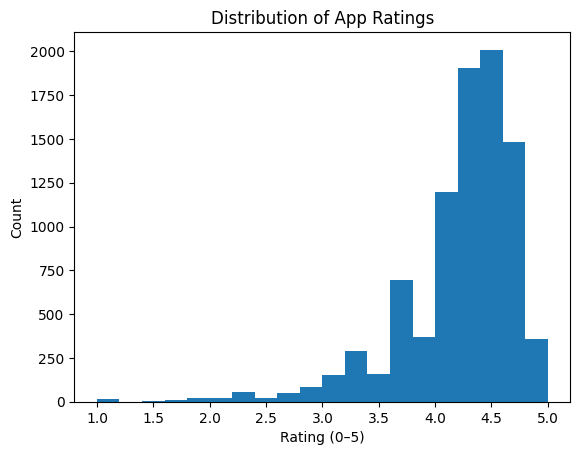

In [5]:
# Rating distribution
df['Rating_clean'].dropna().plot(kind='hist', bins=20)
plt.title('Distribution of App Ratings')
plt.xlabel('Rating (0–5)')
plt.ylabel('Count')
plt.show()

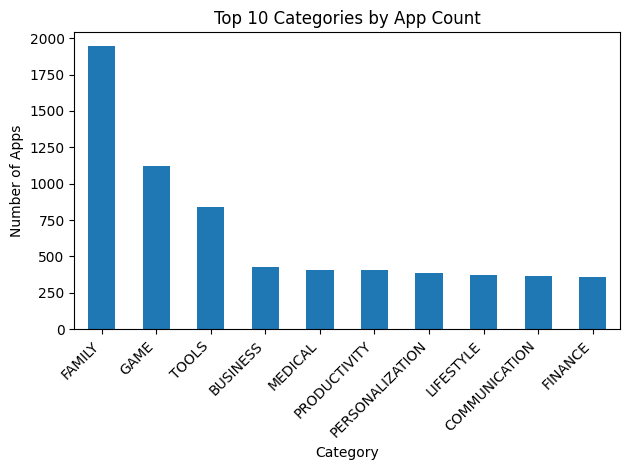

In [6]:
# Top Categories by app count
if 'Category_clean' in df.columns and 'App' in df.columns:
    (df.groupby('Category_clean')['App'].count()
       .sort_values(ascending=False).head(10)
       .plot(kind='bar'))
    plt.title('Top 10 Categories by App Count')
    plt.xlabel('Category')
    plt.ylabel('Number of Apps')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

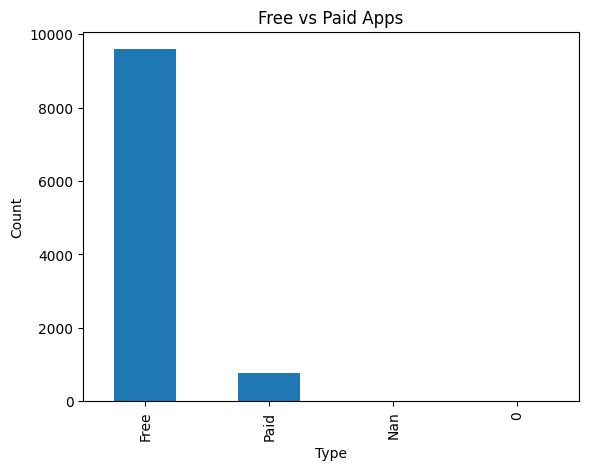

In [7]:
# Free vs Paid counts
if 'Type_clean' in df.columns:
    df['Type_clean'].value_counts(dropna=False).plot(kind='bar')
    plt.title('Free vs Paid Apps')
    plt.xlabel('Type')
    plt.ylabel('Count')
    plt.show()

## 6) Bivariate EDA

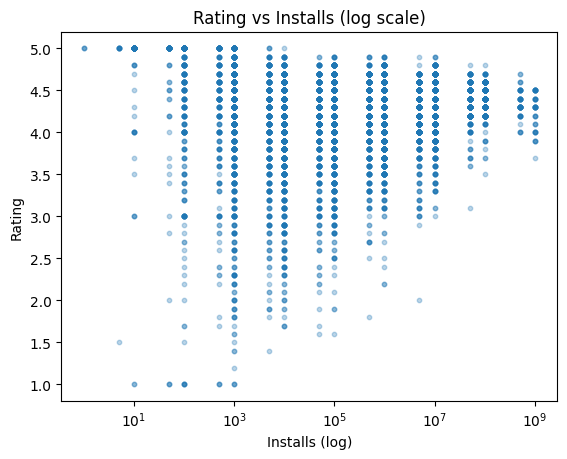

Spearman corr (Rating, Installs): 0.06268888401286322


In [8]:
# Rating vs Installs
subset = df[['Rating_clean','Installs_clean']].dropna()
subset = subset[subset['Installs_clean'] > 0]
plt.scatter(subset['Installs_clean'], subset['Rating_clean'], alpha=0.3, s=10)
plt.xscale('log')
plt.title('Rating vs Installs (log scale)')
plt.xlabel('Installs (log)')
plt.ylabel('Rating')
plt.show()

# Spearman correlation
print("Spearman corr (Rating, Installs):", subset['Rating_clean'].corr(subset['Installs_clean'], method='spearman'))

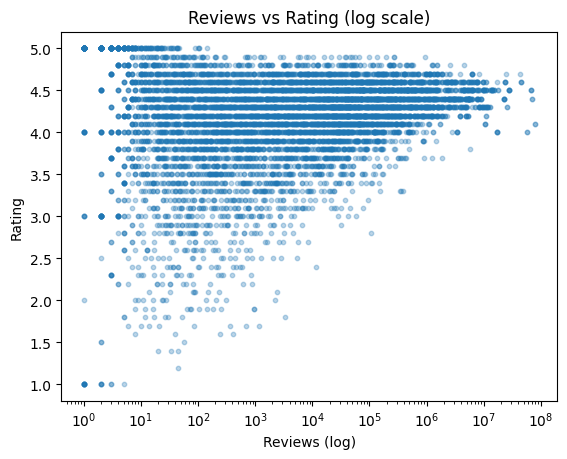

Spearman corr (Rating, Reviews): 0.15049112249052762


In [9]:
# Reviews vs Rating
subset = df[['Rating_clean','Reviews_clean']].dropna()
subset = subset[subset['Reviews_clean'] > 0]
plt.scatter(subset['Reviews_clean'], subset['Rating_clean'], alpha=0.3, s=10)
plt.xscale('log')
plt.title('Reviews vs Rating (log scale)')
plt.xlabel('Reviews (log)')
plt.ylabel('Rating')
plt.show()

print("Spearman corr (Rating, Reviews):", subset['Rating_clean'].corr(subset['Reviews_clean'], method='spearman'))

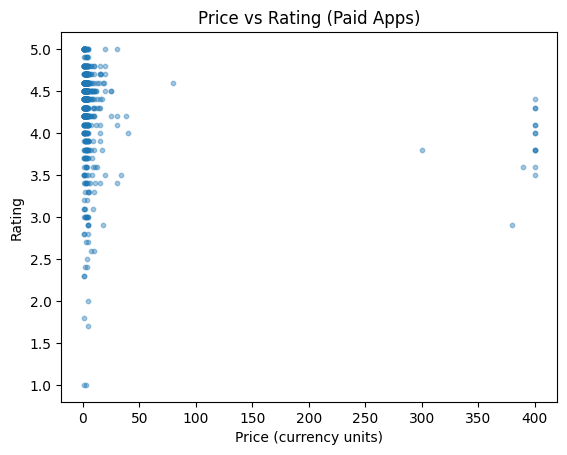

In [10]:
# Price vs Rating for paid apps
if {'Price_clean','Rating_clean','Type_clean'}.issubset(df.columns):
    paid = df[(df['Type_clean']=='Paid') & df['Price_clean'].notna() & df['Rating_clean'].notna()]
    if len(paid) > 0:
        plt.scatter(paid['Price_clean'], paid['Rating_clean'], alpha=0.4, s=10)
        plt.title('Price vs Rating (Paid Apps)')
        plt.xlabel('Price (currency units)')
        plt.ylabel('Rating')
        plt.show()

In [11]:
# Category-level averages
if {'Category_clean','Rating_clean','Installs_clean','Reviews_clean'}.issubset(df.columns):
    cat_agg = (df.groupby('Category_clean')
                 .agg(mean_rating=('Rating_clean','mean'),
                      mean_installs=('Installs_clean','mean'),
                      mean_reviews=('Reviews_clean','mean'),
                      app_count=('App','count'))
                 .sort_values('mean_rating', ascending=False))
    cat_agg.head(10)

## 7) Data quality & outliers

In [12]:
# Simple outlier check using z-score on numeric fields
num_cols = ['Rating_clean','Reviews_clean','Installs_clean','Price_clean','Size_MB']
num_cols = [c for c in num_cols if c in df.columns]
z = (df[num_cols] - df[num_cols].mean())/df[num_cols].std()
outlier_counts = (np.abs(z) > 3).sum().sort_values(ascending=False)
print("Potential outliers (>3 std):\n", outlier_counts)

Potential outliers (>3 std):
 Size_MB           210
Rating_clean      172
Installs_clean    110
Reviews_clean      98
Price_clean        23
dtype: int64


## 8) Insights & business recommendations

###Insights
- The dataset contains a total of 10,358 apps, spanning about 34 categories.
- Approximately 92.6% of apps are free (9,591 free vs 765 paid).
- Average rating is ~4.19 (median 4.30); missing ratings account for ~14.2%.
- Median price of paid apps is ~2.99 (after removing currency symbols).
- Top categories by app count: FAMILY (1943), GAME (1121), TOOLS (843), BUSINESS (427), MEDICAL (408).
- Among categories with ≥30 apps, the highest average ratings are in: EVENTS (4.44), EDUCATION (4.38), ART_AND_DESIGN (4.36).
- Columns with the most missing values: Size_MB: 14.7%, Rating_clean: 14.2%, Reviews_clean: 0.0%.


###Recommendations
- Aim to maintain app ratings ≥ 4.2 — apps with higher ratings tend to have stronger installs and engagement.
- Adopt a freemium model where possible: most apps are free, and monetization via in-app purchases is more scalable than upfront pricing.
- Optimize app size (Size_MB) — larger apps may discourage downloads.
- Benchmark against top-performing categories — replicate UX/UI best practices from categories with high installs and ratings.
- Increase review responsiveness and update frequency (Last_Updated_dt) to improve perception and retention.


## 9) Saving cleaned dataset

In [13]:
# Save cleaned dataset
df.to_csv('googleplaystore_cleaned.csv', index=False)
print("Saved: googleplaystore_cleaned.csv")

Saved: googleplaystore_cleaned.csv
